<span style="color:#000000; font-size:1.2em; text-align:right">Data Scientist II Technical Challenge</span>

<span style="color:#e01760; font-size:2em; align=center">Task 4: Real-world Scenario</span>

<font color="#6E6E6E" align="center">Cristina M. Sánchez Maíz | csmaiz@gmail.com | [LinkedIn](https://www.linkedin.com/in/csmaiz/) </font> 

**Tasks:** 

Consider the following business problem:
Your company wants to improve customer satisfaction by understanding the main topics and sentiments expressed in customer reviews. Your task is to:
- Use topic modeling to identify the main topics in the customer reviews.
- Summarize the findings and suggest actionable insights for business improvements. 

**Deliverables:**
- Explanation of the topic modeling process.
- Summary of the main topics identified.
- Actionable insights based on the analysis.

# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for NLP
import re
from textblob import TextBlob
import nltk 
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
# For evaluating techniques
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
  confusion_matrix, roc_curve, auc, precision_recall_curve

import matplotlib
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification


In [1]:
pd.set_option('display.max_colwidth', None) # avoid truncate columns content

NameError: name 'pd' is not defined

# Load dataset


In [3]:
df = pd.read_csv("../output/Task3/reviews_with_scores.csv",delimiter=",")
df.head(10)

,Unnamed: 0,review_id,customer_id,review_text,preprocessed_review,vader_score,textblob_score,vader_label,textblob_label,bert_score,bert_label,bert_label_3categ
0,1,2,2,"Terrible service, will not buy from here again.",terrible service buy,-0.4767,-1.000000,negative,negative,0.001188,negative,negative
1,2,3,44,"Average quality, you get what you pay for.",average quality get pay,-0.1027,-0.150000,negative,negative,0.591803,positive,positive
2,3,4,6,"Great product, very satisfied with the quality and performance.",great product satisfied quality performance,0.7845,0.650000,positive,positive,0.999857,positive,positive
3,4,5,46,"Very disappointed with the product, not as described.",disappointed product described,-0.4767,-0.750000,negative,negative,0.000211,negative,negative
4,5,6,43,"Excellent service, highly recommend!",excellent service highly recommend,0.7574,0.580000,positive,positive,0.999873,positive,positive
5,6,7,18,The item arrived damaged and customer service was unhelpful.,item arrived damaged customer service unhelpful,-0.4404,0.000000,negative,negative,0.000206,negative,negative
6,7,8,8,Fast delivery and the product works perfectly!,fast delivery product work perfectly,0.6369,0.600000,positive,positive,0.999871,positive,positive
7,8,9,57,The item arrived damaged and customer service was unhelpful.,item arrived damaged customer service unhelpful,-0.4404,0.000000,negative,negative,0.000206,negative,negative
8,9,10,65,"The service was acceptable, but could be improved.",service acceptable could improved,0.6597,0.000000,positive,negative,0.028429,negative,neutral
9,10,11,66,"Decent product, but there are better options available.",decent product better option available,0.4404,0.355556,positive,positive,0.979263,positive,positive


In [4]:
df[["review_text", "vader_label", "bert_label", "bert_label_3categ", "bert_score"]].drop_duplicates()

,review_text,vader_label,bert_label,bert_label_3categ,bert_score
0,"Terrible service, will not buy from here again.",negative,negative,negative,0.001188
1,"Average quality, you get what you pay for.",negative,positive,positive,0.591803
2,"Great product, very satisfied with the quality and performance.",positive,positive,positive,0.999857
3,"Very disappointed with the product, not as described.",negative,negative,negative,0.000211
4,"Excellent service, highly recommend!",positive,positive,positive,0.999873
5,The item arrived damaged and customer service was unhelpful.,negative,negative,negative,0.000206
6,Fast delivery and the product works perfectly!,positive,positive,positive,0.999871
8,"The service was acceptable, but could be improved.",positive,negative,neutral,0.028429
9,"Decent product, but there are better options available.",positive,positive,positive,0.979263
12,"Poor quality, would not recommend.",negative,negative,negative,0.000832


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           980 non-null    int64  
 1   review_id            980 non-null    int64  
 2   customer_id          980 non-null    int64  
 3   review_text          980 non-null    object 
 4   preprocessed_review  980 non-null    object 
 5   vader_score          980 non-null    float64
 6   textblob_score       980 non-null    float64
 7   vader_label          980 non-null    object 
 8   textblob_label       980 non-null    object 
 9   bert_score           980 non-null    float64
 10  bert_label           980 non-null    object 
 11  bert_label_3categ    980 non-null    object 
dtypes: float64(3), int64(3), object(6)
memory usage: 92.0+ KB


# Topic Modeling

## LDA

In [8]:
df_negative = df[df["bert_label_3categ"] == "negative"].drop_duplicates(["review_text"])
df_negative

,Unnamed: 0,review_id,customer_id,review_text,preprocessed_review,vader_score,textblob_score,vader_label,textblob_label,bert_score,bert_label,bert_label_3categ
0,1,2,2,"Terrible service, will not buy from here again.",terrible service buy,-0.4767,-1.000000,negative,negative,0.001188,negative,negative
3,4,5,46,"Very disappointed with the product, not as described.",disappointed product described,-0.4767,-0.750000,negative,negative,0.000211,negative,negative
5,6,7,18,The item arrived damaged and customer service was unhelpful.,item arrived damaged customer service unhelpful,-0.4404,0.000000,negative,negative,0.000206,negative,negative
12,13,14,35,"Poor quality, would not recommend.",poor quality would recommend,-0.1531,-0.400000,negative,negative,0.000832,negative,negative
14,15,16,65,"The product works fine, but took a long time to arrive.",product work fine took long time arrive,0.2023,0.183333,positive,positive,0.004364,negative,negative
15,16,17,67,"The product broke after one use, very unhappy.",product broke one use unhappy,-0.6808,-0.600000,negative,negative,0.000230,negative,negative


In [74]:
import pandas as pd
import gensim
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.corpora import Dictionary
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora
from gensim.models import LdaModel
from IPython.display import display, HTML
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis



display(HTML("<style>.container { max-width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
display(HTML("<style>.input_area { max-width:100% !important; }</style>"))





#df_negative = df[df["bert_label_3categ"] == "negative"].drop_duplicates(["review_text"])
df_negative = df[df["bert_label_3categ"] == "negative"].copy()

df_negative["tokens"] = df_negative['preprocessed_review'].apply(lambda pp: pp.split(" "))


def run_LDA(df, num_topics):

    

    id2word = Dictionary(df["tokens"])
    #id2word.filter_extremes(no_below=2, no_above=1.0)
    print(id2word)

    corpus = [id2word.doc2bow(text) for text in df["tokens"]]

    # Train the LDA model
    lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=3)

    for idx, topic in lda_model.print_topics(num_topics=num_topics, num_words=5):
        print(f"Topic {idx}: {topic}")
        
    return lda_model, corpus, id2word



In [75]:
lda_model, corpus, id2word = run_LDA(df_negative, num_topics=4)

Dictionary<25 unique tokens: ['buy', 'service', 'terrible', 'described', 'disappointed']...>
Topic 0: 0.107*"buy" + 0.107*"terrible" + 0.106*"service" + 0.096*"long" + 0.096*"fine"
Topic 1: 0.230*"product" + 0.132*"broke" + 0.132*"unhappy" + 0.132*"use" + 0.132*"one"
Topic 2: 0.238*"recommend" + 0.237*"quality" + 0.237*"would" + 0.237*"poor" + 0.011*"product"
Topic 3: 0.160*"service" + 0.159*"item" + 0.159*"damaged" + 0.158*"unhelpful" + 0.158*"arrived"


In [76]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
pyLDAvis.display(LDAvis_prepared)

In [77]:
def get_dominant_topic(lda_model, corpus):
    """
    Determines the dominant topic for a given document.

    Args:
        lda_model: Trained LDA model.
        corpus: Document-term matrix.

    Returns:
        Dominant topic number.
    """
    topic_dist = lda_model[corpus]
    dominant_topic = max(topic_dist, key=lambda x: x[1])[0]
    return dominant_topic


def get_topic_dist(lda_model, corpus):
    """
    Determines the dominant topic for a given document.

    Args:
        lda_model: Trained LDA model.
        corpus: Document-term matrix.

    Returns:
        Dominant topic number.
    """
    topic_dist = lda_model[corpus]
    return topic_dist



def assign_topics_by_lambda(lda_model, doc_term_matrix, lambda_value):
    '''
    Assigns topics to documents based on a lambda threshold.

    Args:
    lda_model: Trained LDA model.
    doc_term_matrix: Document-term matrix.
    lambda_value: Threshold for topic probability.

    Returns:
    List of assigned topics for each document.
    '''

    topic_dist = lda_model[doc_term_matrix]
    relevant_topics = [(topic_id, prob) for topic_id, prob in topic_dist if prob >= lambda_value]

    if relevant_topics:
        # Sort by probability in descending order
        relevant_topics.sort(key=lambda x: x[1], reverse=True)
        return relevant_topics[0][0]  # Return the topic index with the highest probability
    else:
        return -1  # No topic meets the lambda threshold


# Example usage:
lambda_threshold = 0.7

df_negative['topic_dist'] = df_negative['tokens'].apply(lambda x: get_topic_dist(lda_model, id2word.doc2bow(x)))

df_negative['topic_number'] = df_negative['tokens'].apply(lambda x: get_dominant_topic(lda_model, id2word.doc2bow(x)))
df_negative['topic_number_lambda'] = df_negative['tokens'].apply(lambda x: assign_topics_by_lambda(lda_model, id2word.doc2bow(x), lambda_value=lambda_threshold))

df_negative
df_negative[["review_text", "topic_number", "topic_number_lambda", "topic_dist"]].drop_duplicates(["review_text", "topic_number", "topic_number_lambda"])

,review_text,topic_number,topic_number_lambda,topic_dist
0,"Terrible service, will not buy from here again.",0,0,"[(0, 0.81006503), (1, 0.062566906), (2, 0.06250794), (3, 0.06486015)]"
3,"Very disappointed with the product, not as described.",1,1,"[(0, 0.06308478), (1, 0.8115955), (2, 0.062791355), (3, 0.062528394)]"
5,The item arrived damaged and customer service was unhelpful.,3,3,"[(0, 0.03596725), (1, 0.035782654), (2, 0.03571602), (3, 0.89253414)]"
12,"Poor quality, would not recommend.",2,2,"[(0, 0.05000467), (1, 0.05000111), (2, 0.84999305), (3, 0.05000111)]"
14,"The product works fine, but took a long time to arrive.",0,0,"[(0, 0.90541494), (1, 0.031969413), (2, 0.031276815), (3, 0.03133883)]"
15,"The product broke after one use, very unhappy.",1,1,"[(0, 0.041886), (1, 0.87474805), (2, 0.041688245), (3, 0.041677736)]"


In [78]:
lambd = 0.2 # a specific relevance metric value

all_topics = {}
num_topics = lda_model.num_topics 
num_terms = 10 

for i in range(1,num_topics+1): ## Correct range
    topic = LDAvis_prepared.topic_info[LDAvis_prepared.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    display(topic)
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values
pd.DataFrame(all_topics)





,Term,Freq,Total,Category,logprob,loglift,relevance
0,buy,76.189916,77.246207,Topic1,-2.2362,0.9553,0.31700
2,terrible,76.174330,77.247525,Topic1,-2.2364,0.9550,0.31672
17,long,68.514328,71.679630,Topic1,-2.3424,0.9239,0.27064
16,fine,68.496973,71.675782,Topic1,-2.3427,0.9237,0.27042
15,arrive,68.458423,71.684206,Topic1,-2.3432,0.9230,0.26976
20,work,68.424324,71.684910,Topic1,-2.3437,0.9225,0.26926
19,took,68.428436,71.692188,Topic1,-2.3437,0.9224,0.26918
18,time,68.365593,71.690273,Topic1,-2.3446,0.9215,0.26828
1,service,75.784081,149.334693,Topic1,-2.2416,0.2907,-0.21576
5,product,68.485037,172.883010,Topic1,-2.3429,0.0430,-0.43418


,Term,Freq,Total,Category,logprob,loglift,relevance
9,item,70.013637,73.058811,Topic2,-1.8403,1.4069,0.75746
8,damaged,69.940394,73.053130,Topic2,-1.8414,1.4059,0.75644
10,unhelpful,69.882042,73.049693,Topic2,-1.8422,1.4051,0.75564
6,arrived,69.841766,73.048892,Topic2,-1.8428,1.4046,0.75512
7,customer,69.829767,73.047571,Topic2,-1.8430,1.4044,0.75492
1,service,70.474677,149.334693,Topic2,-1.8338,0.6985,0.19204
19,took,2.552424,71.692188,Topic2,-5.1520,-1.8859,-2.53912
18,time,2.523278,71.690273,Topic2,-5.1635,-1.8973,-2.55054
15,arrive,2.445870,71.684206,Topic2,-5.1946,-1.9284,-2.58164
20,work,2.431972,71.684910,Topic2,-5.2003,-1.9341,-2.58734


,Term,Freq,Total,Category,logprob,loglift,relevance
21,broke,56.862163,57.736131,Topic3,-2.0233,1.4593,0.76278
23,unhappy,56.859311,57.735521,Topic3,-2.0233,1.4593,0.76278
24,use,56.833364,57.737511,Topic3,-2.0238,1.4588,0.76228
22,one,56.783635,57.740057,Topic3,-2.0247,1.4579,0.76138
3,described,41.867902,45.462274,Topic3,-2.3294,1.3922,0.64788
4,disappointed,41.774763,45.467387,Topic3,-2.3316,1.3899,0.64560
5,product,98.815616,172.883010,Topic3,-1.4707,0.9152,0.43802
7,customer,2.615899,73.047571,Topic3,-5.1023,-1.8549,-2.50438
6,arrived,2.598667,73.048892,Topic3,-5.1089,-1.8616,-2.51106
10,unhelpful,2.577046,73.049693,Topic3,-5.1173,-1.8699,-2.51938


,Term,Freq,Total,Category,logprob,loglift,relevance
13,recommend,70.062895,71.264642,Topic4,-1.4375,1.8346,1.18018
12,quality,70.011944,71.262835,Topic4,-1.4382,1.8339,1.17948
14,would,69.995066,71.260226,Topic4,-1.4384,1.8337,1.17928
11,poor,69.939000,71.256948,Topic4,-1.4392,1.8330,1.17856
4,disappointed,3.032918,45.467387,Topic4,-4.5773,-0.8558,-1.60010
3,described,2.995384,45.462274,Topic4,-4.5898,-0.8682,-1.61252
5,product,3.120268,172.883010,Topic4,-4.5489,-2.1631,-2.64026
22,one,0.344007,57.740057,Topic4,-6.7540,-3.2714,-3.96792
24,use,0.309953,57.737511,Topic4,-6.8582,-3.3756,-4.07212
21,broke,0.309932,57.736131,Topic4,-6.8583,-3.3756,-4.07214


,Topic 1,Topic 2,Topic 3,Topic 4
0,buy,item,broke,recommend
1,terrible,damaged,unhappy,quality
2,long,unhelpful,use,would
3,fine,arrived,one,poor
4,arrive,customer,described,disappointed
5,work,service,disappointed,described
6,took,took,product,product
7,time,time,customer,one
8,service,arrive,arrived,use
9,product,work,unhelpful,broke


In [79]:
for cluster in range(0,num_topics):
    print(f"Cluster {cluster}:")
    for review in df_negative[df_negative['topic_number'] == cluster]['review_text'].unique():
        print(f" - {review}")

Cluster 0:
 - Terrible service, will not buy from here again.
 - The product works fine, but took a long time to arrive.
Cluster 1:
 - Very disappointed with the product, not as described.
 - The product broke after one use, very unhappy.
Cluster 2:
 - Poor quality, would not recommend.
Cluster 3:
 - The item arrived damaged and customer service was unhelpful.


24/08/08 20:22:38 WARN JavaUtils: Attempt to delete using native Unix OS command failed for path = /private/var/folders/13/tsck2zgx0qb1r_r_nr36b6wr4gb5k8/T/spark-900963b4-f0a4-47a2-8ec9-6b08f3f10c8c/userFiles-aa4c9705-c9f7-4325-84a6-b492b2b659c8. Falling back to Java IO way
java.io.IOException: Failed to delete: /private/var/folders/13/tsck2zgx0qb1r_r_nr36b6wr4gb5k8/T/spark-900963b4-f0a4-47a2-8ec9-6b08f3f10c8c/userFiles-aa4c9705-c9f7-4325-84a6-b492b2b659c8
	at org.apache.spark.network.util.JavaUtils.deleteRecursivelyUsingUnixNative(JavaUtils.java:171)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:110)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:91)
	at org.apache.spark.util.Utils$.deleteRecursively(Utils.scala:1141)
	at org.apache.spark.SparkEnv.stop(SparkEnv.scala:105)
	at org.apache.spark.SparkContext.$anonfun$stop$23(SparkContext.scala:2108)
	at org.apache.spark.util.Utils$.tryLogNonFatalError(Utils.scala:1419)
	at org.

Dataset size and characteristics: Large datasets might benefit from scalable methods like Non-Negative Matrix Factorization (NMF).

Desired number of topics: If you need a predetermined number of topics, LDA might be suitable.

Interpretability: For easily understandable topics, LDA often works well.

Based on the topic-sentiment analysis, you can:

- Identify topics with high negative sentiment: Focus on improving these areas.
- Analyze topics with high positive sentiment: Leverage these strengths.
- Compare topics over time: Detect trends and emerging issues.
- Correlate topics with customer demographics: Identify specific customer segments.

Note:

This is a basic example. You might need to adjust parameters (number of topics, preprocessing steps, etc.) based on your dataset.
Consider using more advanced topic modeling techniques like Non-Negative Matrix Factorization (NMF) or Latent Semantic Analysis (LSA).
For deeper sentiment analysis, explore fine-grained sentiment classification or aspect-based sentiment analysis.
By combining topic modeling and sentiment analysis, you can gain valuable insights into customer feedback and drive business improvements.

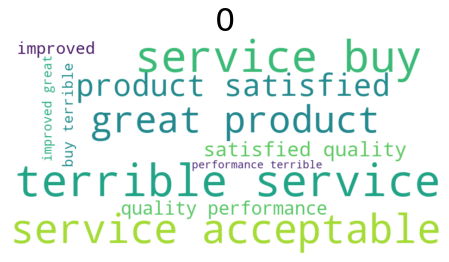

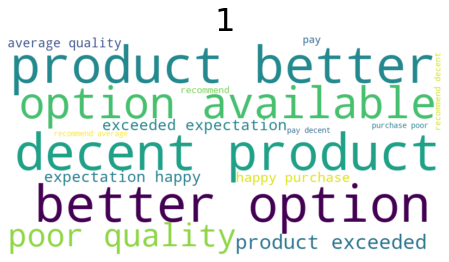

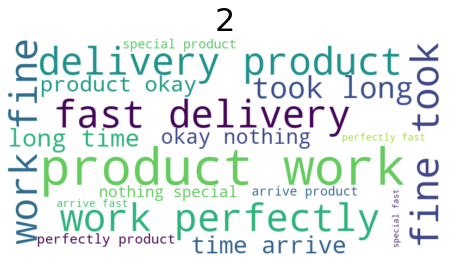

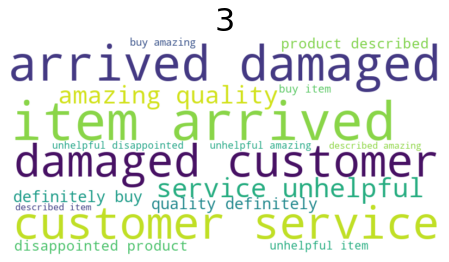

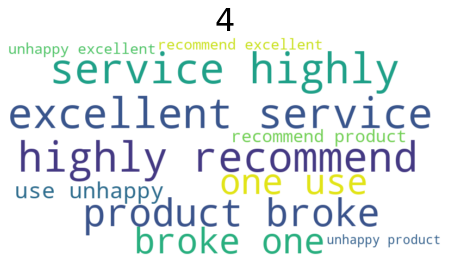

In [159]:
from wordcloud import WordCloud

# Create word clouds for each topic
for topic, reviews in df.groupby('lda_topic'):
    text = ' '.join(reviews['preprocessed_review'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(topic)

    plt.show()

## Large language model

In [141]:
import os
os.environ["http_proxy"]=""
os.environ["https_proxy"]=""

In [ ]:
from transformers import AutoModel, AutoTokenizer
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import numpy as np
import torch
from transformers import DistilBertTokenizer, DistilBertModel


# Code extracted from Hugging face web - https://huggingface.co/distilbert/distilbert-base-uncased
# Load pre-trained model and tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

'''
Function to get embeddings for a list of texts
function tokenizes the input texts, generates embeddings using a pre-trained model, 
and averages the token embeddings to produce a single vector representation for each document.
''' 
def get_embeddings(texts, model, tokenizer):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).numpy()

# Generate embeddings for the reviews
embeddings = get_embeddings(df['review_text'].tolist(), model, tokenizer)



In [ ]:
df_unique = df.drop_duplicates(subset=['review_text'])
df_unique

In [157]:
df_negative.shape

(6, 17)

In [8]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt


df_negative = df[df["bert_label_3categ"].isin(["negative"])].drop_duplicates(["review_text"])
display(df_negative)

# Remove duplicate reviews before running the clustering since duplicate reviews 
# can skew the clustering results by giving more weight to the repeated texts
#df_unique = df_negative.drop_duplicates(subset=['review_text'])[["review_text"]]

embeddings = get_embeddings(df_negative['review_text'].tolist(), model, tokenizer)

# Apply Hierarchical Clustering
hierarchical_cluster = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
hierarchical_cluster.fit(embeddings)

# Create the linkage matrix
Z = linkage(embeddings, 'ward')


# Plot the dendrogram
plt.figure(figsize=(5, 3))
plt.title('Hierarchical Clustering Dendrogram')
dendrogram(Z)
plt.show()





,Unnamed: 0,review_id,customer_id,review_text,preprocessed_review,vader_score,textblob_score,vader_label,textblob_label,bert_score,bert_label,bert_label_3categ
0,1,2,2,"Terrible service, will not buy from here again.",terrible service buy,-0.4767,-1.000000,negative,negative,0.001188,negative,negative
3,4,5,46,"Very disappointed with the product, not as described.",disappointed product described,-0.4767,-0.750000,negative,negative,0.000211,negative,negative
5,6,7,18,The item arrived damaged and customer service was unhelpful.,item arrived damaged customer service unhelpful,-0.4404,0.000000,negative,negative,0.000206,negative,negative
12,13,14,35,"Poor quality, would not recommend.",poor quality would recommend,-0.1531,-0.400000,negative,negative,0.000832,negative,negative
14,15,16,65,"The product works fine, but took a long time to arrive.",product work fine took long time arrive,0.2023,0.183333,positive,positive,0.004364,negative,negative
15,16,17,67,"The product broke after one use, very unhappy.",product broke one use unhappy,-0.6808,-0.600000,negative,negative,0.000230,negative,negative


NameError: name 'get_embeddings' is not defined

In [173]:
# Decide the number of clusters by cutting the dendrogram
num_clusters = 4  # Adjust based on the dendrogram
from scipy.cluster.hierarchy import fcluster
labels = fcluster(Z, num_clusters, criterion='maxclust')
df_negative['cluster_label'] = labels


##df.drop("cluster_label",errors='ignore')  

# Merge the cluster labels back to the original dataframe
##df = pd.merge(df, df_unique[['review_text', 'cluster_label']], on='review_text', how='left')

# Display the number of documents per cluster
print(df_negative['cluster_label'].value_counts())
df_negative[["review_text", "cluster_label"]].drop_duplicates()



cluster_label
1    2
2    2
3    1
4    1
Name: count, dtype: int64


,review_text,cluster_label
0,"Terrible service, will not buy from here again.",1
3,"Very disappointed with the product, not as described.",2
5,The item arrived damaged and customer service was unhelpful.,3
12,"Poor quality, would not recommend.",1
14,"The product works fine, but took a long time to arrive.",4
15,"The product broke after one use, very unhappy.",2


In [175]:
for cluster in range(1,num_clusters+1):
    print(f"Cluster {cluster}:")
    for review in df_unique[df_unique['cluster_label'] == cluster]['review_text'].unique():
        print(f" - {review}")

Cluster 1:
 - Terrible service, will not buy from here again.
 - Poor quality, would not recommend.
Cluster 2:
 - Very disappointed with the product, not as described.
 - The product broke after one use, very unhappy.
Cluster 3:
 - The item arrived damaged and customer service was unhelpful.
Cluster 4:
 - The product works fine, but took a long time to arrive.


### Comments

- Cluster 1 
   * corresponds to the customers who won't recommend buying in the e-commerce platform --> DETRACTORS
- Cluster 2:
   * Product Quality issues
   * Negative Feedback on Product Description
- Cluster 3:
  * Customer service issues
- Cluster 4:
  * Delivery and Shipping Issues


### Actionable insights based on the analysis.

Based on the identified topics and sentiments, here are some actionable insights for the business:

**Improve Customer Service:**
- Conduct training sessions for customer service representatives to improve their communication skills and responsiveness.
- Implement a better tracking system for customer inquiries to ensure timely responses.

**Enhance Product Descriptions:**
- Review and update product descriptions to ensure they accurately reflect the product features and quality.
- Include more detailed images and customer reviews to set realistic expectations.

**Address Product Quality Issues:**
- Investigate and address any recurring quality issues in the products.
- Consider quality checks and improvements in the production process.


**Streamline Delivery and Shipping:**
- Partner with reliable shipping companies to ensure timely and accurate deliveries.
- Implement a tracking system for customers to monitor their orders in real-time.


**Leverage Positive Feedback:**
- Highlight positive reviews and testimonials in marketing materials.
- Encourage satisfied customers to leave reviews and share their experiences.

**Focus on Loyalty Programs:**
- Implement or enhance loyalty programs to reward repeat customers.
- Offer exclusive discounts or early access to new products for loyal customers.